# Navigation

---

In this notebook, you will learn how to use the Unity ML-Agents environment for the first project of the [Deep Reinforcement Learning Nanodegree](https://www.udacity.com/course/deep-reinforcement-learning-nanodegree--nd893).

### 1. Start the Environment

We begin by importing some necessary packages.  If the code cell below returns an error, please revisit the project instructions to double-check that you have installed [Unity ML-Agents](https://github.com/Unity-Technologies/ml-agents/blob/master/docs/Installation.md) and [NumPy](http://www.numpy.org/).

In [1]:
from unityagents import UnityEnvironment
import numpy as np

Next, we will start the environment!  **_Before running the code cell below_**, change the `file_name` parameter to match the location of the Unity environment that you downloaded.

- **Mac**: `"path/to/Banana.app"`
- **Windows** (x86): `"path/to/Banana_Windows_x86/Banana.exe"`
- **Windows** (x86_64): `"path/to/Banana_Windows_x86_64/Banana.exe"`
- **Linux** (x86): `"path/to/Banana_Linux/Banana.x86"`
- **Linux** (x86_64): `"path/to/Banana_Linux/Banana.x86_64"`
- **Linux** (x86, headless): `"path/to/Banana_Linux_NoVis/Banana.x86"`
- **Linux** (x86_64, headless): `"path/to/Banana_Linux_NoVis/Banana.x86_64"`

For instance, if you are using a Mac, then you downloaded `Banana.app`.  If this file is in the same folder as the notebook, then the line below should appear as follows:
```
env = UnityEnvironment(file_name="Banana.app")
```

In [2]:
env = UnityEnvironment(file_name="Banana_Windows_x86_64/Banana.exe")

INFO:unityagents:
'Academy' started successfully!
Unity Academy name: Academy
        Number of Brains: 1
        Number of External Brains : 1
        Lesson number : 0
        Reset Parameters :
		
Unity brain name: BananaBrain
        Number of Visual Observations (per agent): 0
        Vector Observation space type: continuous
        Vector Observation space size (per agent): 37
        Number of stacked Vector Observation: 1
        Vector Action space type: discrete
        Vector Action space size (per agent): 4
        Vector Action descriptions: , , , 


Environments contain **_brains_** which are responsible for deciding the actions of their associated agents. Here we check for the first brain available, and set it as the default brain we will be controlling from Python.

In [3]:
# get the default brain
brain_name = env.brain_names[0]
brain = env.brains[brain_name]

### 2. Examine the State and Action Spaces

The simulation contains a single agent that navigates a large environment.  At each time step, it has four actions at its disposal:
- `0` - walk forward 
- `1` - walk backward
- `2` - turn left
- `3` - turn right

The state space has `37` dimensions and contains the agent's velocity, along with ray-based perception of objects around agent's forward direction.  A reward of `+1` is provided for collecting a yellow banana, and a reward of `-1` is provided for collecting a blue banana. 

Run the code cell below to print some information about the environment.

In [4]:
# reset the environment
env_info = env.reset(train_mode=True)[brain_name]

# number of agents in the environment
print('Number of agents:', len(env_info.agents))

# number of actions
action_size = brain.vector_action_space_size
print('Number of actions:', action_size)

# examine the state space 
state = env_info.vector_observations[0]
print('States look like:', state)
state_size = len(state)
print('States have length:', state_size)

Number of agents: 1
Number of actions: 4
States look like: [1.         0.         0.         0.         0.84408134 0.
 0.         1.         0.         0.0748472  0.         1.
 0.         0.         0.25755    1.         0.         0.
 0.         0.74177343 0.         1.         0.         0.
 0.25854847 0.         0.         1.         0.         0.09355672
 0.         1.         0.         0.         0.31969345 0.
 0.        ]
States have length: 37


### 3. Take Random Actions in the Environment

In the next code cell, you will learn how to use the Python API to control the agent and receive feedback from the environment.

Once this cell is executed, you will watch the agent's performance, if it selects an action (uniformly) at random with each time step.  A window should pop up that allows you to observe the agent, as it moves through the environment.  

Of course, as part of the project, you'll have to change the code so that the agent is able to use its experience to gradually choose better actions when interacting with the environment!

In [5]:
env_info = env.reset(train_mode=False)[brain_name] # reset the environment
state = env_info.vector_observations[0]            # get the current state
score = 0                                          # initialize the score
while True:
    action = np.random.randint(action_size)        # select an action
    env_info = env.step(action)[brain_name]        # send the action to the environment
    next_state = env_info.vector_observations[0]   # get the next state
    reward = env_info.rewards[0]                   # get the reward
    done = env_info.local_done[0]                  # see if episode has finished
    score += reward                                # update the score
    state = next_state                             # roll over the state to next time step
    if done:
        print("\rFinal Score = {:3d}".format(int(score)))
        break
    else:
        print("\rScore: {:3d}".format(int(score)), end="")

Final Score =   0


### 4. It's Your Turn!

Now it's your turn to train your own agent to solve the environment!  When training the environment, set `train_mode=True`, so that the line for resetting the environment looks like the following:
```python
env_info = env.reset(train_mode=True)[brain_name]
```

#### A. Import Double DQN Agent and Training/Testing Code

In [6]:
from ddqn_agent import DDQNPERAgent
import train_test as tt
%load_ext autoreload
%autoreload 2
%matplotlib inline

# Tolerance for detecting whether two states are different.
tor_dstate = 1e-3

#### B. Test for Repeated States

State Deltas: Max = 1.10e+01, Min = 0.00e+00


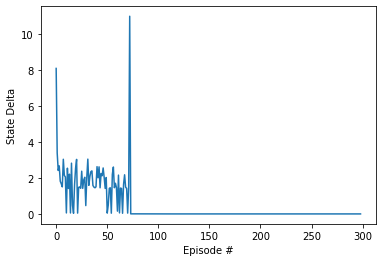

In [7]:
# The agent always takes the backward action. It will eventually back onto a wall and be stuck there. If the action
# selected by the DQN model is backward in such a stucked situation, the backward action will be selected again and
# again since the input to the model, the state, is essentially the same as illustrated here.

actions = [1]
tt.test_repeat_states(env, actions)

State Deltas: Max = 2.49e+00, Min = 0.00e+00


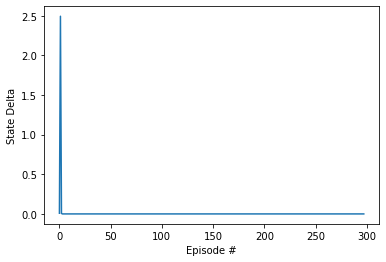

In [8]:
# The agent takes a right turn and then a left turn. As shown here, the state keeps repeating itself after these
# two actions. If the DQN model first selects a right turn and then a left turn, it will likely keep selecting a
# right turn followed by a left turn since the input states to the model are essentially the same. The same will
# happen for two opposite move actions (e.g., forward followed by backward).

actions = [3, 2]
tt.test_repeat_states(env, actions)

State Deltas: Max = 4.10e+00, Min = 6.23e-07


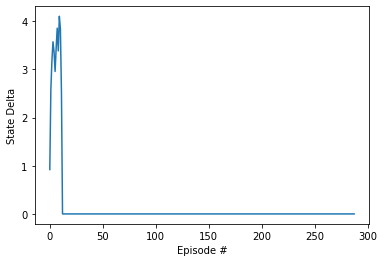

In [9]:
# The agent takes 12 consecutive left turns and the state is repeated. This shows the angular span for each
# turn is one-twelfth of a circle.

actions = [2] * 12
tt.test_repeat_states(env, actions)

#### C. Train the Model

Episode  200	Average Score:   1.04
Episode  400	Average Score:   6.59
Episode  600	Average Score:   8.70
Episode  800	Average Score:  10.34
Episode 1000	Average Score:  13.59 (Best Solved Average Score:  13.63 at Episode  894!)
Episode 1200	Average Score:  14.46 (Best Solved Average Score:  14.82 at Episode  966!)
Episode 1400	Average Score:  13.36 (Best Solved Average Score:  14.82 at Episode  966!)
Episode 1600	Average Score:  13.67 (Best Solved Average Score:  14.82 at Episode  966!)
Episode 1800	Average Score:  13.49 (Best Solved Average Score:  14.82 at Episode  966!)
Episode 2000	Average Score:  14.61 (Best Solved Average Score:  14.82 at Episode  966!)
First Solved Average Score:  13.07 at Episode  804!


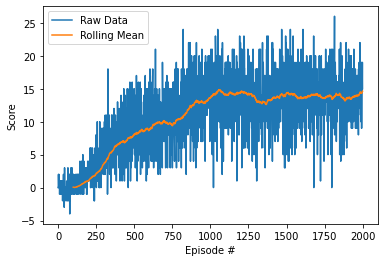

In [10]:
qnet_name = "QNet_DDQNPER"

agent_params = {'state_size': state_size,
                'action_size': action_size,
                'tor_dstate': tor_dstate,
                'lrn_rate': 7.5e-5,
                'hsize1': 64,
                'hsize2': 64}

agent_train = DDQNPERAgent(**agent_params)

train_params = {'env': env,
                'agent': agent_train,
                'n_episodes': 2000,
                'print_every': 200,
                'beta_start': 0.5,
                'qnet_name': qnet_name}

scores = tt.train_ddqn_per(**train_params)
tt.plot_train_scores(scores)

#### D. Test the Model

Test Results: MeanScore =  13.15, MaxScore =  24, MinScore =  -1


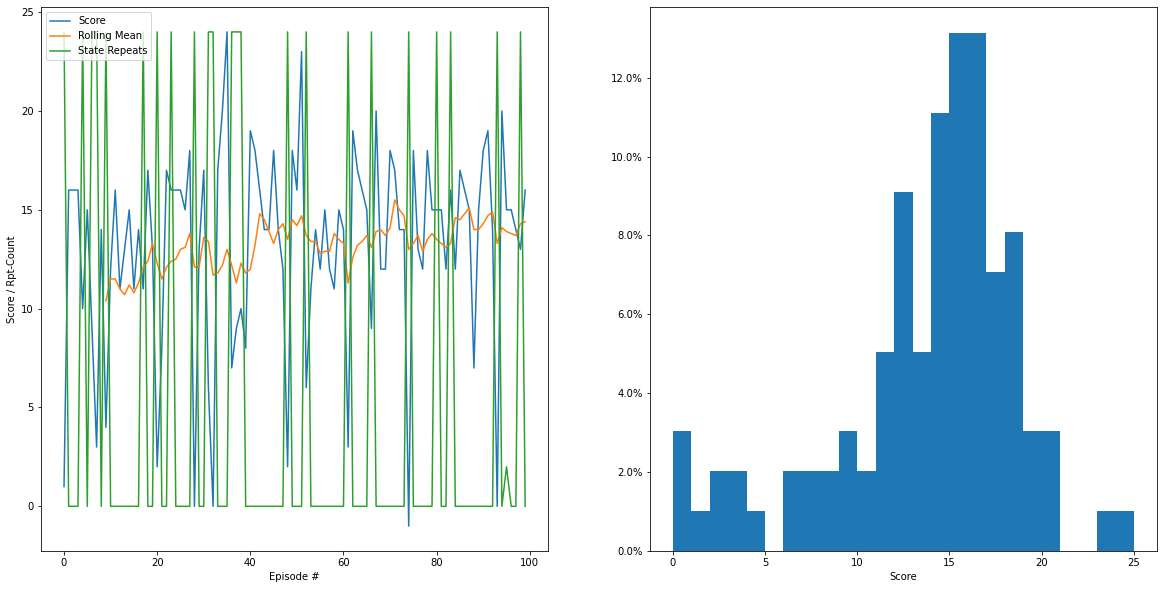

In [11]:
agent_test = DDQNPERAgent(**agent_params)
agent_test.load_qnet(qnet_name)
scores, n_rpts = tt.test_ddqn_per(env, agent_test, tor_dstate, n_episodes=100)
tt.plot_test_scores(scores, n_rpts)

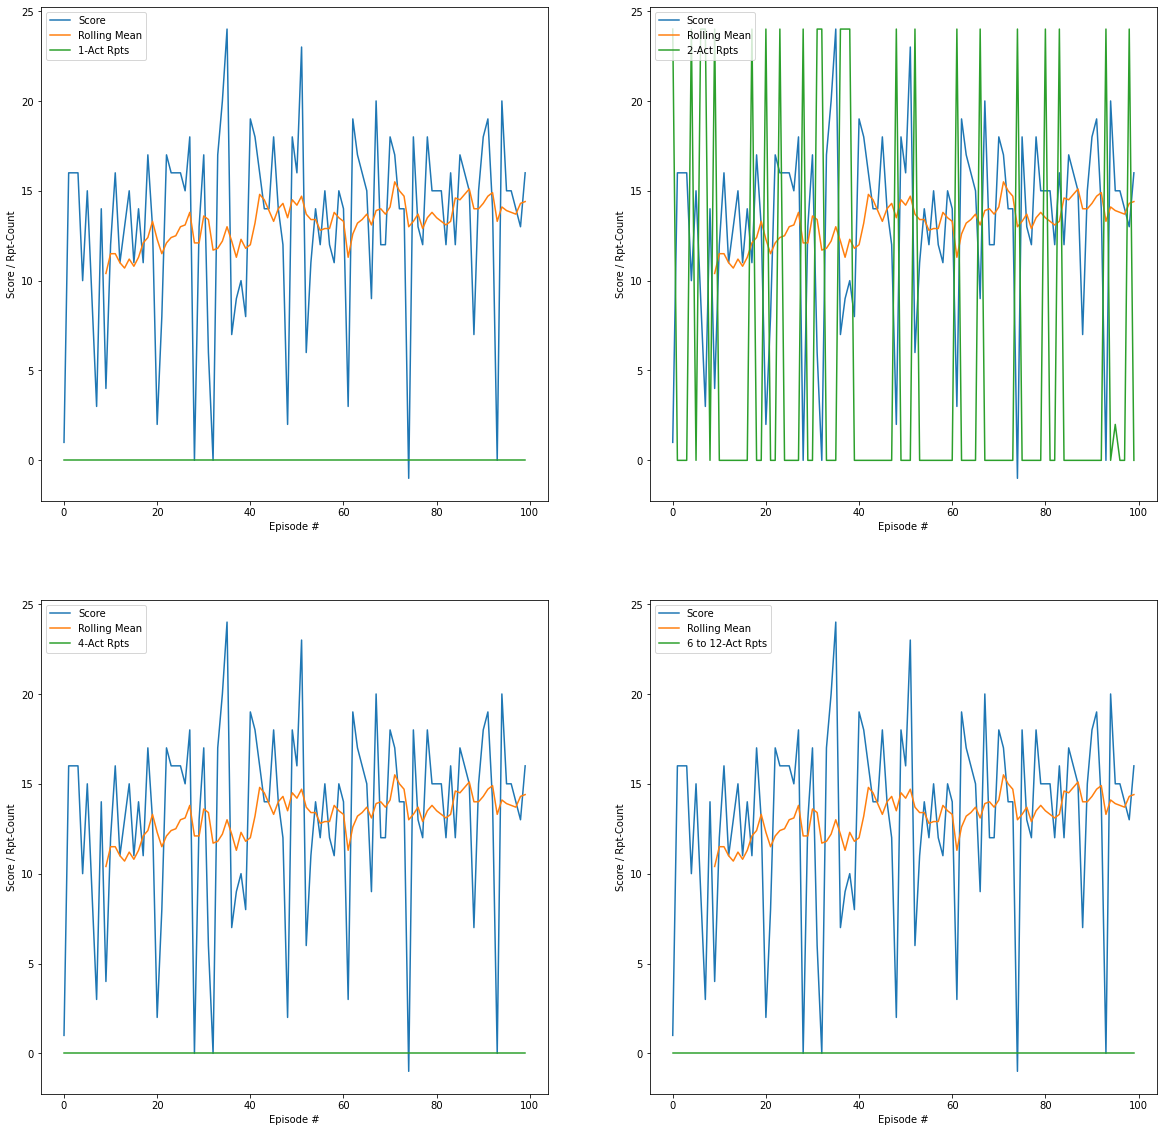

In [12]:
# Show details of the state repeat counts.
tt.plot_srpt_results(scores, n_rpts)

#### E. Post-process to Remove Repeated States

Test Results: MeanScore =  15.12, MaxScore =  25, MinScore =   7


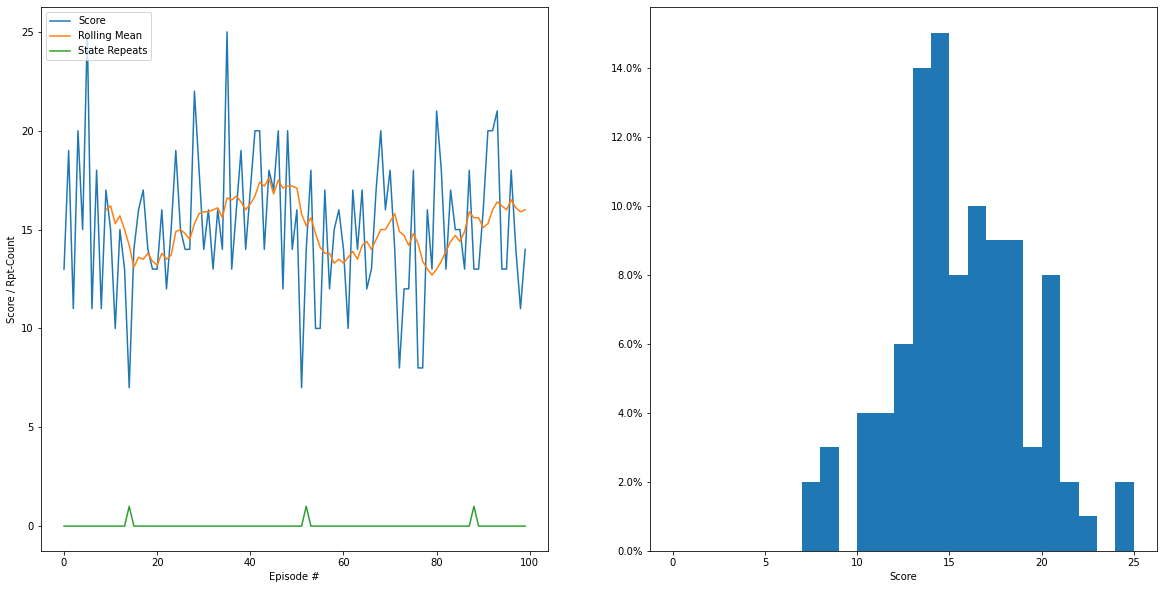

In [13]:
agent_test = DDQNPERAgent(**agent_params)
agent_test.load_qnet(qnet_name)
scores, n_rpts = tt.test_ddqn_per(env, agent_test, tor_dstate, n_episodes=100, post_srdet=7)
tt.plot_test_scores(scores, n_rpts)

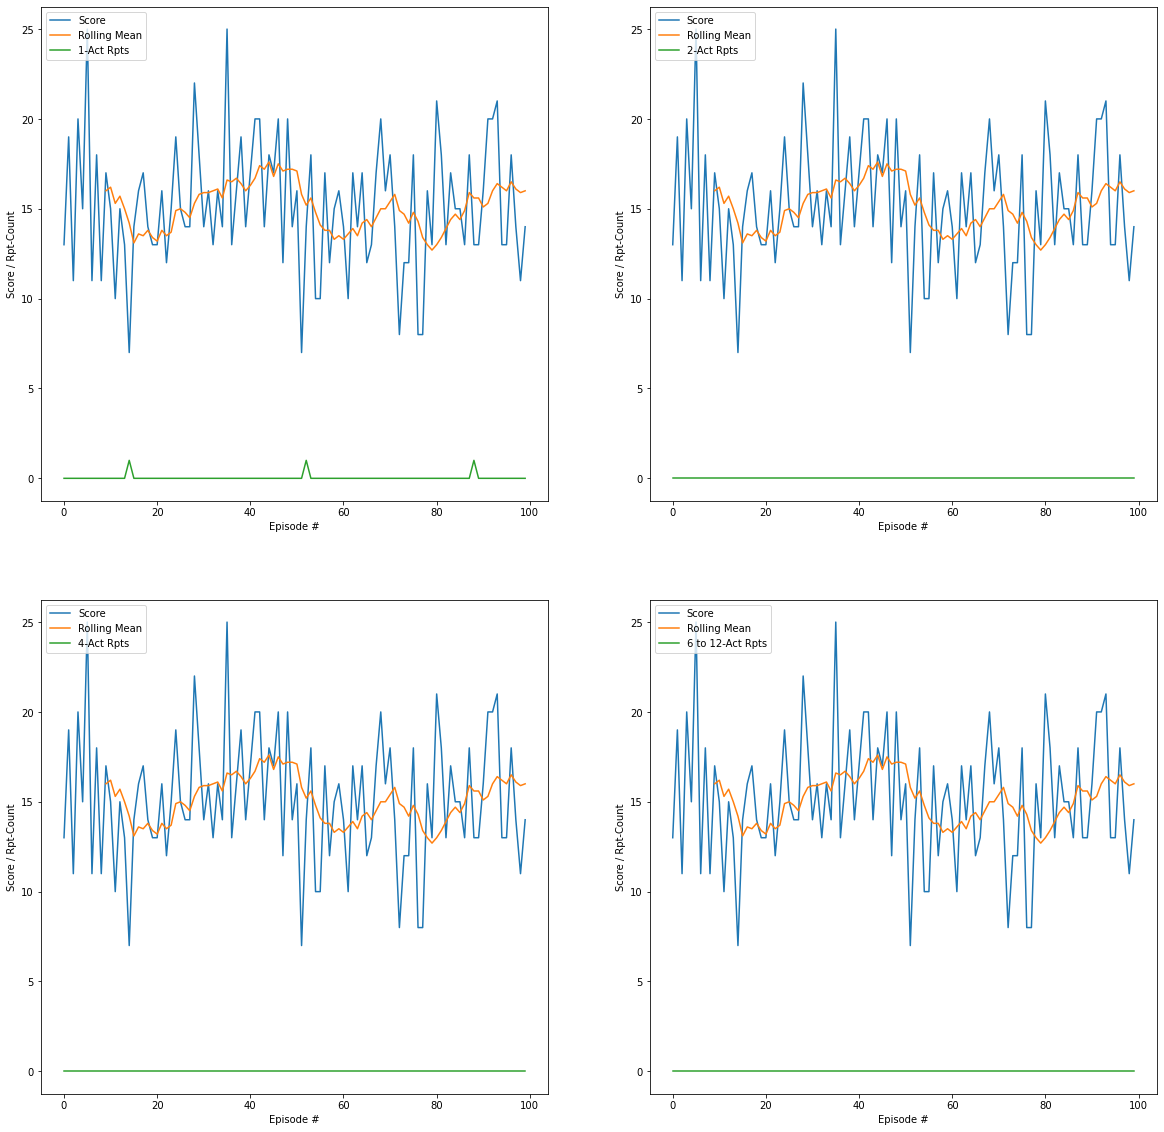

In [14]:
# Show details of the state repeat counts.
tt.plot_srpt_results(scores, n_rpts)

When finished, you can close the environment.

In [15]:
env.close()